# Profiling python scripts





[Description and most examples modified from https://www.futurelearn.com/courses/python-in-hpc/1/steps/591385]

In ideal case the speed-up should be directly proportional to the number of processing units, i.e. doubling the number of processing units should give a relative speed-up of two. In real-world problems this is rarely the case.

There are several factors which can limit the parallel scaling. Typically, parallel program needs to perform some additional operations which are not present in serial program. There can be some redundant computations, data needs to be communicated, and the processing units need to be synchronized. If there is imbalance in the distribution of the workload, execution time is limited by the slowest execution unit, and others need to wait its completion.

There can be also serial parts in the program i.e. parts that cannot be parallelized. If we designate with  $p_{f}$  the fraction of the problem that can be parallelized, then the maximum possible speed-up (so called **Amdahl’s law**) is

$S_{max} = \frac{1}{1 - p_f}$

As an example, if only 90% of the problem can be parallelized, maximum speed-up is 10 even if one was using 1000 CPU cores.




# Important! We have to setup the environment variables based on where the notebook is running #

In [1]:
import os
import sys
from pathlib import Path

# Identify the environment and set the ROOT directory accordingly
if "COLAB_RELEASE_TAG" in os.environ:
    ROOT = Path("/content")
    UV_RUN = ""
elif "KAGGLE_KERNEL_RUN_TYPE" in os.environ:
    ROOT = Path("/kaggle/working")
    UV_RUN = ""
elif os.environ.get("CODESPACES") == "true":
    ROOT = Path("/workspaces")
    UV_RUN = ""
else:
    # In local vscode, sys.prefix points to the .venv folder.
    # The notebook and .venv are typically in the parent directory of sys.prefix
    ROOT = Path(sys.prefix).parent
    # In local environments, we need to use 'uv run' to ensure the correct environment is used
    UV_RUN = "uv run"

# Change the current working directory to ROOT
os.chdir(ROOT)
print("Current working directory is set to:", ROOT)

Current working directory is set to: /content


## Check the number of processors in your computer

The number of processes should be related to the number of physical processors in the computer.

In [2]:
# !lscpu

In [3]:
import psutil

# Number of logical cores
logical_cores_psutil = psutil.cpu_count(logical=True)

# Number of physical cores
physical_cores_psutil = psutil.cpu_count(logical=False)

# Print the results
print(f"Logical Cores (psutil): {logical_cores_psutil}")
print(f"Physical Cores (psutil): {physical_cores_psutil}")

Logical Cores (psutil): 2
Physical Cores (psutil): 1


## Using timing functions and time magics

### Using `time` module

In order to get a bigger picture of the performance of a program, it can be useful to measure the time spent in a specific region of the program.

Python standard library has a time module which provides various time-related functions. In particular the `time.process_time` function can be used for measuring a specific code region. Instead, use `time.time()` to measure Wall time, not the specific process time:

In [4]:
# example using arithmetic functions with lists
# and FOR LOOPs.
import numpy as np
import time

# create a list of 1 million random numbers
x = [np.random.uniform(-1, 1) for _ in range(1000000)]

# create a dummy function to do some arithmetic computing
def calculate_np(a):
    result = 0
    for val in a:
        result += np.exp(val) * np.sin(val)
    return result

t0 = time.time()
calculate_np(x)
t1 = time.time()

print("Time spent", t1 - t0)

Time spent 4.117446184158325


In [5]:
# example using arithmetic functions with lists
# without FOR LOOPs.
# THIS IS BETTER
import numpy as np
import time

def calculate_list_noloop(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

# create a list of 1 million random numbers
x = [np.random.uniform(-1, 1) for _ in range(1000000)]

t0 = time.time()
calculate_list_noloop(x)
t1 = time.time()

print("Time spent", t1 - t0)

Time spent 0.18520855903625488


In [6]:
# example using arithmetic functions with numpy arrays
# without FOR LOOPs.
# THIS IS THE BEST OPTION, OF COURSE.
import numpy as np
import time

def calculate_np_noloop(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

# create a list of 1 million random numbers
# x = [np.random.uniform(-1, 1) for _ in range(1000000)]
# create a numpy array of 1 million random numbers
x = np.array([np.random.uniform(-1, 1) for _ in range(1000000)])

t0 = time.time()
calculate_np_noloop(x)
t1 = time.time()

print("Time spent", t1 - t0)

Time spent 0.05275297164916992


Check this thread in Stackoverflow to understand differences between absolute time and relative time for a computer process:

https://stackoverflow.com/questions/25785243/understanding-time-perf-counter-and-time-process-time

### Using `timeit` module

Use `timeit` for better precision. `timeit`executes the code a number of times and returns the mean:

In [7]:
# timeit basic usage
import timeit
import time

yourcode = """
for i in range(10000000):
    pass
"""

# Use timer=time.process_time to measure only the CPU time consumed by the process, ignoring wait times.
comptime = timeit.timeit(yourcode, number=10, timer=time.time) # Executes 10 veces and returns the sum of the time

print(f"Average execution time: {comptime / 10:.5f} seconds")

Average execution time: 0.39260 seconds


In [8]:
import timeit
import time

# create a list of 1 million random numbers
x = [np.random.uniform(-1, 1) for _ in range(1000000)]

# create a dummy function to do some arithmetic computing
def calculate_np(a):
    result = 0
    for val in a:
        result += np.exp(val) * np.sin(val)
    return result

yourcode = """
calculate_np(x)
"""
# Use timer=time.process_time to measure only the CPU time consumed by the process, ignoring wait times.
comptime = timeit.timeit(yourcode, number=10,
                         globals=globals(), # so that timeit have access to variables/namespace (x, calculate_np) defined outside the local exec env
                         timer=time.time) # Executes 10 veces and returns the sum of the time

print(f"Average execution time: {comptime / 10:.5f} seconds")

Average execution time: 3.17610 seconds


### Using timeit magics

The magic commands ``%timeit`` (for a single line) and ``%%timeit`` (for the full cell block) have simplier sintax and add the benefit of executing the task several times automatically and take the mean execution time to return more accurate results.

In [9]:
# use %timeit for single line timing:
import numpy as np

def calculate(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

x = np.random.uniform(-1, 1, 1000000)

%timeit calculate(x)

46.6 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# %%timeit
# use %%timeit AT THE BEGINNING OF THE CELL to time several lines of code
for r in range(100):
  calculate(x)

### Using time magics

The `%%time` magic command times a single run of a function, similar to the Unix time command. It is therefore less accurate, but faster than `%%timeit`. It shows the CPU time and wall-clock time taken by the code. In addition, it shows the results of the execution of the cell.

In [11]:
# use %time for single line timing:
import numpy as np

def calculate(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

x = np.random.uniform(-1, 1, 1000000)

%time calculate(x)

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 23.8 ms


np.float64(330657.01304129715)

In [12]:
# %%time
# use %%time ate the beginning of the cell to time several lines of code
for r in range(100):
  calculate(x)

## Using %prun profiler
The prun profiler, part of Python's cProfile module, is a powerful built-in tool designed to help developers analyze the performance of their code. It provides detailed insights into the execution time of Python functions, helping to identify bottlenecks and optimize performance. By measuring the number of function calls and the time spent in each, prun enables efficient profiling of even complex programs.

`prun` is an IPython magic command, making it highly convenient for quick, interactive profiling within an IPython or Jupyter Notebook environment.

`cProfile` is a standard Python module, offering more comprehensive profiling capabilities for both small scripts and large applications. It's suitable for systematic performance analysis and debugging.

In [13]:
%prun calculate(x)

You can get more info on ``timeit`` ``prun`` and ``mrun`` in the man pages, and some examples here:

- https://ipython-books.github.io/42-profiling-your-code-easily-with-cprofile-and-ipython/

- https://jakevdp.github.io/PythonDataScienceHandbook/01.07-timing-and-profiling.html



## Using cProfile

cProfile is powerful profiling and analysis tool included in the Python standard library. For a resume of the (complex) documentation of the standard python profilers check:

https://docs.python.org/3.7/library/profile.html

To test it, we will use the following example, extracted from:

 https://github.com/csc-training/hpc-python/tree/master/performance/cprofile



In [14]:
# Clone the github repositoy to Google Colaboratory. Don't worry, usually it is VERY fast
import os

if not os.path.exists(f'{ROOT}/hpc-python'):
    !git clone https://github.com/csc-training/hpc-python.git
else:
    print("Repository 'hpc-python' already exists.")

Cloning into 'hpc-python'...
remote: Enumerating objects: 2821, done.
remote: Counting objects: 100% (442/442), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 2821 (delta 92), reused 277 (delta 71), pack-reused 2379 (from 1)
Receiving objects: 100% (2821/2821), 4.84 MiB | 11.26 MiB/s, done.
Resolving deltas: 100% (1492/1492), done.


In [15]:
# # cd to the cprofile directory to run the example
%cd {ROOT}/hpc-python/performance/cprofile

/content/hpc-python/performance/cprofile


To understand why you should use `%cd` magic instead of `!cd`, check this link :

https://stackoverflow.com/questions/48298146/changing-directory-in-google-colab-breaking-out-of-the-python-interpreter


### Using cProfile from the command line to profile another script.

cProfile can be run as an script to profile another script. Execute cProfile to gather performance data

In [16]:
# run the cprofile example. Profiling data is stored in profile.data
!python -m cProfile -o profile.data heat_main.py

Heat equation solver
Diffusion constant: 0.5
Input file: bottle.dat
Parameters
----------
  nx=200 ny=200 dx=0.01 dy=0.01
  time steps=200  image interval=4000
Simulation finished in 20.861671447753906 s


We can check the results of the heat equation,  although this is not important at this moment for our profiling purposes:


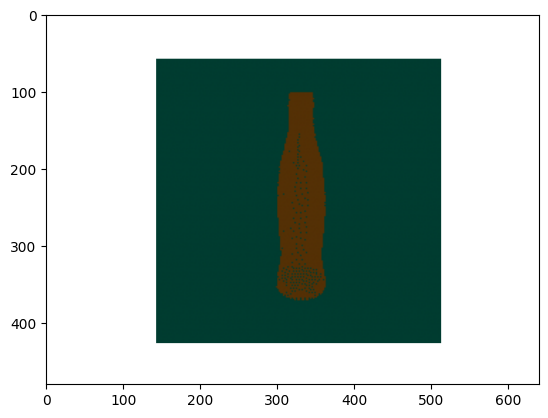

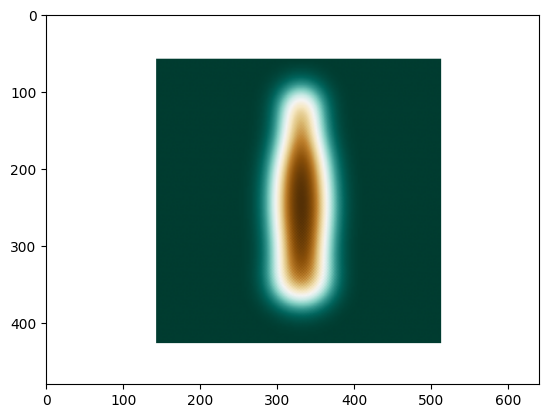

In [17]:
# importing pyplot and image from matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img

# reading png image file
im1 = img.imread('heat_000.png')
im2 = img.imread('heat_200.png')
# show image
plt.imshow(im1)
plt.figure()
plt.imshow(im2)

We can use ``pstats`` to pretty print profiling data generated by cProfile:

In [18]:
# If you want to run interactively, you can use:
# !python -m pstats profile.data
# in the interactive console that opens, try the following commands in order:
# strip # removes the file paths from the function names
# sort time # sorts the profiling results by the amount of time spent in each function
# stats 5 # shows a summary of the top N functions based on the current sort order
# quit
# Below is a programmatic way to do the same:
import pstats
from pstats import SortKey

p = pstats.Stats("profile.data")
p.strip_dirs()
p.sort_stats(SortKey.TIME)
p.print_stats(5)

Mon Feb  2 11:44:52 2026    profile.data

         1385753 function calls (1367218 primitive calls) in 22.604 seconds

   Ordered by: internal time
   List reduced from 3997 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      200   20.861    0.104   20.861    0.104 heat.py:13(evolve)
     7554    0.104    0.000    0.197    0.000 inspect.py:882(cleandoc)
        4    0.086    0.022    0.086    0.022 image.py:575(draw)
      326    0.072    0.000    0.072    0.000 {built-in method marshal.loads}
        2    0.066    0.033    0.066    0.033 {method 'encode' of 'ImagingEncoder' objects}




In [19]:
# Run pstats in terminal
# !python -m pstats profile.data
# in the interactive console that opens, try the following commands in order:
# strip    # removes the file path from function names
# sort time    # sorts the profiling results by the amount of time spent in each function
# stats 5    # shows a summary of the top N functions based on the current sort order
# quit    # exit

### Using cProfile in an script

Another way of using cProfile is calling it from within a script:

In [20]:
# another way of using cProfile is calling it from within a script
import cProfile
cProfile.run('2+2')

         3 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {built-in method builtins.exec}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




In [21]:
# another way of using cProfile is calling it from within a script
# Remember: if using a function call or script, enclose its name in ''
# Use 'sort' to sort by any of the report columns
import cProfile
cProfile.run('calculate(x)', sort='tottime')

         583 function calls (569 primitive calls) in 0.030 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.025    0.025    0.025    0.025 ipython-input-1079575747.py:4(calculate)
      2/0    0.001    0.001    0.000          {method 'poll' of 'select.epoll' objects}
      5/3    0.001    0.000    0.002    0.001 events.py:86(_run)
        1    0.001    0.001    0.001    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        2    0.000    0.000    0.000    0.000 {method 'recv' of '_socket.socket' objects}
        2    0.000    0.000    0.000    0.000 iostream.py:221(_really_send)
      2/1    0.000    0.000    0.025    0.025 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
       72    0.000    0.000    0.000    0.000 enum.py:1543(_get_value)
      2/1    0.000    0.000    0.025    0.025 {built-in method builtins.exec}
       14    0.000    0.

In [22]:
# # cd to the defautl working dir before executing next cell
%cd {ROOT}

/content


In [23]:
# Instead of printing the output at the end of the profile run,
# you can save the results to a file:
cProfile.run('calculate(x)', 'calculate_stats')

The `Stats` module can also be called from within an script:

In [24]:
from pstats import Stats
p = Stats('calculate_stats')
p.strip_dirs() # removes all leading path information from file names
p.sort_stats('time') # sort by computing time
p.print_stats(5) # show first 5 rows

Mon Feb  2 11:44:53 2026    calculate_stats

         330 function calls (323 primitive calls) in 0.025 seconds

   Ordered by: internal time
   List reduced from 95 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.023    0.023    0.024    0.024 ipython-input-1079575747.py:4(calculate)
        1    0.001    0.001    0.001    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.000    0.000    0.000    0.000 attrsettr.py:66(_get_attr_opt)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        7    0.000    0.000    0.000    0.000 socket.py:632(send)




In [25]:
# this is typically combined in as a single-line command:
p.strip_dirs().sort_stats('time').print_stats(5)

Mon Feb  2 11:44:53 2026    calculate_stats

         330 function calls (323 primitive calls) in 0.025 seconds

   Ordered by: internal time
   List reduced from 95 to 5 due to restriction <5>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.023    0.023    0.024    0.024 ipython-input-1079575747.py:4(calculate)
        1    0.001    0.001    0.001    0.001 {method 'reduce' of 'numpy.ufunc' objects}
        3    0.000    0.000    0.000    0.000 attrsettr.py:66(_get_attr_opt)
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}
        7    0.000    0.000    0.000    0.000 socket.py:632(send)




Typically, to profile your ML algorithms you will be using cProfile in a very basic configuration, like this:

```
def train_model():
  train_history = model.fit(...)

cProfile.run('train_model()', prof_stats, sort='tottime')
```




# Profiling a parallel (multiprocess) application



## `py-spy` profiler

`py-spy` (https://github.com/benfred/py-spy) is a lightweight sampling profiler for that can profile any Python program in execution, including those using multiple processes or threads. It does not require modifying the source code and can capture profiles of child processes.

`py-spy` works on Linux, OSX, Windows and FreeBSD.

`py-spy` works from the command line and takes either the PID of the program you want to sample from or the command line of the python program you want to run. py-spy has three subcommands record, top and dump:

- `record` stores profiles to a file using a flame graph.
- `top` shows a live view of what functions are taking the most time in your python program, similar to the Unix top command.
- `dump` displays the current call stack for each python thread.



In [26]:
# If you are not in the local environment, install py-spy
if UV_RUN == "":
    !pip install py-spy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 20.6 MB/s eta 0:00:00


In [27]:
# # cd to the cprofile directory to run the heat difussion example
%cd {ROOT}/hpc-python/performance/cprofile
# Run the profiler. The -- separates the arguments for py-spy from the command it will run:
# We use {UV_RUN} to conditionally use 'uv run' only in local specific environments
!{UV_RUN} py-spy record -o profile.svg -- python heat_main.py

/content/hpc-python/performance/cprofile
py-spy> Sampling process 100 times a second. Press Control-C to exit.

Heat equation solver
Diffusion constant: 0.5
Input file: bottle.dat
Parameters
----------
  nx=200 ny=200 dx=0.01 dy=0.01
  time steps=200  image interval=4000
Simulation finished in 34.88407373428345 s

py-spy> Stopped sampling because process exited
py-spy> Wrote flamegraph data to 'profile.svg'. Samples: 3740 Errors: 0
Error: No child process (os error 10)


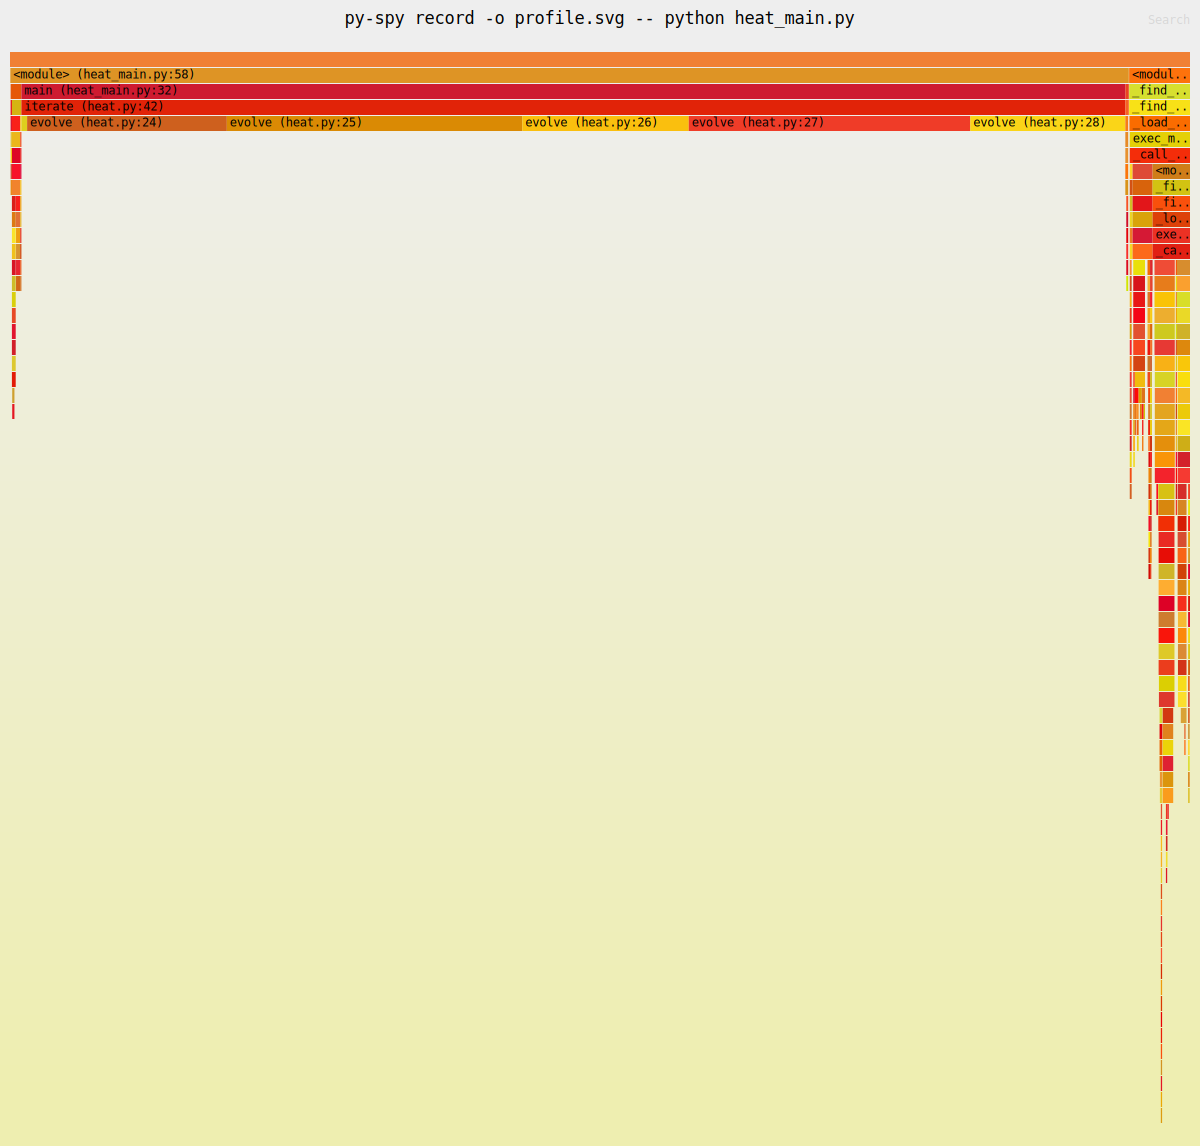

In [28]:
# open svg file with the flame graph
from IPython.display import SVG

SVG(filename='profile.svg')

In [29]:
# interactive execution. This is similar to the `top` Linux command:
!{UV_RUN} py-spy top -- python heat_main.py


























Total Samples 10
GIL: 100.00%, Active: 100.00%, Threads: 1

  %Own   %Total  OwnTime  TotalTime  Function (filename)                        
 30.00%  30.00%   0.030s    0.030s   _compile_bytecode (<frozen importlib._boots
 20.00%  20.00%   0.020s    0.020s   getargs (numpy/_utils/_inspect.py)
 20.00% 100.00%   0.020s    0.100s   _call_with_frames_removed (<frozen importli
 10.00%  10.00%   0.010s    0.010s   <module> (numbers.py)
 10.00%  10.00%   0.010s    0.010s   _path_split (<frozen importlib._bootstrap_e
 10.00%  20.00%   0.010s    0.020s   _init_module_attrs (<frozen importlib._boot
  0.00%  10.00%   0.000s    0.010s   <module> (pickle.py)
  0.00%  30.00%   0.000s    0.030s   <module> (numpy/_core/fromnumeric.py)
  0.00%  30.00%   0.000s    0.030s   <module> (numpy/_core/_methods.py)
  0.00%  10.00%   0.000s    0.010s   <module> (numpy/linalg/__init__.py)
  0.00% 100.00%   0.000s    0.100s   _find_and_load (<frozen importlib._bootstra
  0.00%  90.00%   0.

## `scalene` profiler


`scalene` (https://github.com/plasma-umass/scalene) is a high-performance CPU, GPU and memory profiler for Python. It runs orders of magnitude faster than many other profilers while delivering far more detailed information.

Thanks to its GPU profiling support, it is extremely useful for machine learning and data processing applications. Scalene’s GPU profiling helps with underutilized GPUs as well as bottlenecks in parallel processing.

Scalene’s CPU profiling differentiates between the time spent in Python and the time spent in native code. NumPy and TensorFlow, two of the more popular libraries, have bottlenecks occurring outside of pure Python code.

Memory Profiling, which tracks Python and native memory usage, identifying leaks and excess allocations. While most profilers track only Python memory, Scalene measures usage in native extensions like C code that is called from Python. What this means is that it detects leaks and can pinpoint inefficient memory allocation patterns with great precision.

The meaning of main columns of the repor:

- "Time Python": How much time was spent in Python code.
"native": How much time was spent in non-Python code (e.g., libraries written in C/C++).
- "system": How much time was spent in the system (e.g., I/O).
- "GPU": (not shown here) How much time spent on the GPU, if your system has an NVIDIA GPU installed.
- "Memory Python": How much of the memory allocation happened on the Python side of the code, as opposed to in non-Python code (e.g., libraries written in C/C++).



In [30]:
# If you are not in the local environment, install scalene
if UV_RUN == "":
    !pip install scalene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.3 MB/s eta 0:00:00


In [31]:
# # cd to the cprofile directory to run the heat difussion example
%cd {ROOT}/hpc-python/performance/cprofile
# run scalene to profile heat_main.py

!COLUMNS=160 {UV_RUN} scalene run heat_main.py

In [32]:
# View profiling results
!COLUMNS=160 {UV_RUN} scalene view --cli

Let's test scalene with our calculate() function:

In [33]:
# # cd to the user dir
%cd {ROOT}

/content


In [37]:
%%file calculate.py
import numpy as np

def calculate(a):
    result = 0
    vector = np.exp(a) * np.sin(a)
    result = vector.sum()
    return result

x = np.random.uniform(-1, 1, 10000000)
print(f"result={calculate(x)}")

Writing calculate.py


In [38]:
# Run profiler
!COLUMNS=160 {UV_RUN} scalene run calculate.py

2026-02-02 11:47:14.873384: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770032834.897568    1631 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770032834.904618    1631 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770032834.922670    1631 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770032834.922711    1631 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770032834.922718    1631 computation_placer.cc:177] computation placer alr

In [39]:
# View profiling results
!COLUMNS=160 {UV_RUN} scalene view --cli

2026-02-02 11:47:53.556353: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770032873.580347    1811 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770032873.590374    1811 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770032873.622015    1811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770032873.622053    1811 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770032873.622058    1811 computation_placer.cc:177] computation placer alr

**Explanation**: most of the time is spent inside `calculate()` function, although creating the large `x` array also accounts for a portion of the time. Within `calculate()`, the mayority of the time is consumed by the computation of `vector`, with a smaller portion spent on `vector.sum`. Notably, the time used for computing `vector` is predominantly attributed to native (C code) operations and secondly to system-level (I/O-bound) processes, rather than Python execution.  

This is a detailed explanation of the columns:

1. **Memory Usage and Histogram**  
   - The memory usage histogram visualizes how memory usage fluctuates throughout the script.  
   - **Max Memory**: is the maximum memory the script used.  
   - **Growth Rate**: indicates the increase in memory allocation over time.

2. **Execution Time**  
   - **File**: `/content/calculate.py`  
   - **% of Time**: 100% of the execution time was spent in this file.  
   - **Total Time**: total execution time.

3. **Line-by-Line Profiling**
    - **`Time (Python)`**: Percentage of time spent executing Python code on that line.
    - **`Time (native)`**: Time spent in native extensions like NumPy.
    - **`Time (system)`**: System-level time (e.g., OS operations like file I/O).
    - **`Memory (Python)`**: Memory usage attributed to Python objects for that line.
    - **`Peak Memory`**: Peak memory usage for that line during execution.
    - **`Timeline/%`**: The relative contribution of that line to the total execution time, visualized as a bar graph.
    - **`Copy (MB/s)`**: Memory copy bandwidth for operations involving arrays or buffers.
